In [1]:
import numpy as np; np.random.seed(1040941203) # For reproducibility (+82-10-4094-1203)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from PIL import ImageFilter

In [2]:
"""
    Step 1. Data exploration & bottleneck features extraction
"""

# Paths of train & test photos
train_path = "../input/data/train_photos/"
test_path = "../input/data/test_photos/"

# Paths of CSV files
train_pid_bid = '../input/data/train_photo_to_biz_ids.csv'
train_bid_label = '../input/data/train.csv'
test_pid_bid = '../input/data/test_photo_to_biz.csv'

# Make dataframes 
train_photos = pd.read_csv(train_pid_bid)
train_label = pd.read_csv(train_bid_label)
train_id = pd.read_csv(train_pid_bid) 
test_photos = pd.read_csv(test_pid_bid)

# Labels dictionary
label_notation = {0: 'good_for_lunch', 1: 'good_for_dinner', 2: 'takes_reservations',  3: 'outdoor_seating',
                  4: 'restaurant_is_expensive', 5: 'has_alcohol', 6: 'has_table_service', 7: 'ambience_is_classy',
                  8: 'good_for_kids'}

Train...


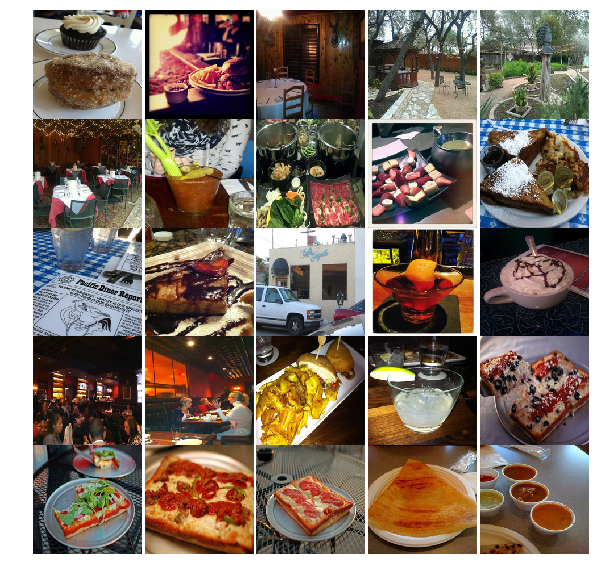

In [3]:
################
print("Train...")
################

# Show 25 images in train set
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)

for x in range(25):
        plt.subplot(5, 5, x+1)
        im = Image.open(train_path + str(train_photos.photo_id[x]) + '.jpg')
        im = im.resize((192, 192), Image.ANTIALIAS)
        plt.imshow(im)
        plt.axis('off')

Test...


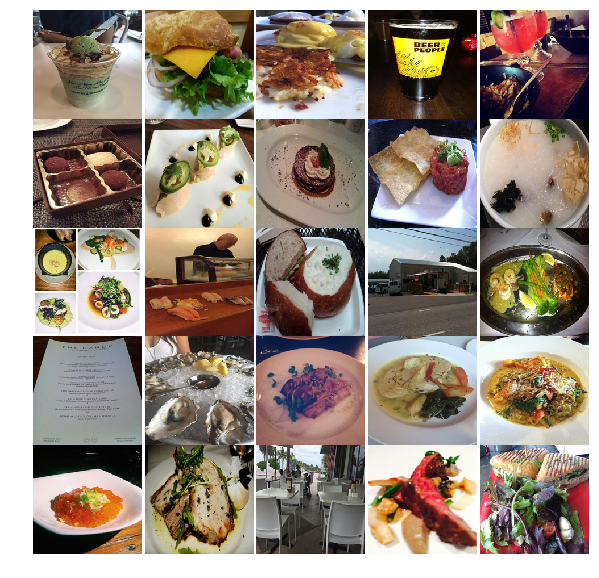

In [4]:
################      
print("Test...")
################

# Show 25 images in test set
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)

for x in range(25):
        plt.subplot(5, 5, x+1)
        im = Image.open(test_path +  str(test_photos.photo_id[x]) + '.jpg')
        im = im.resize((192, 192), Image.ANTIALIAS)
        plt.imshow(im)
        plt.axis('off')

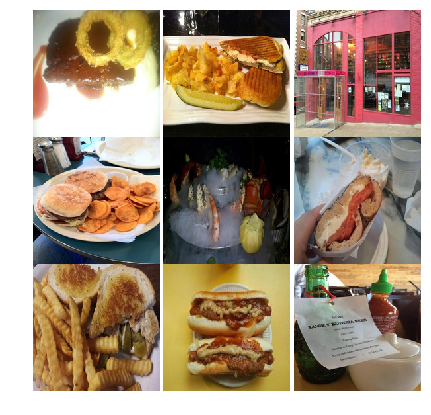

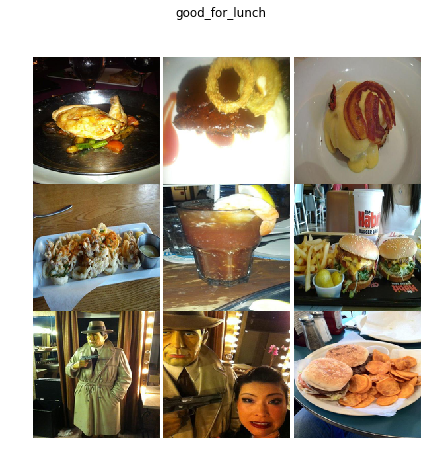

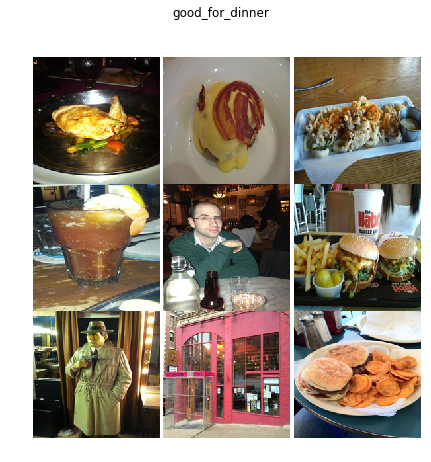

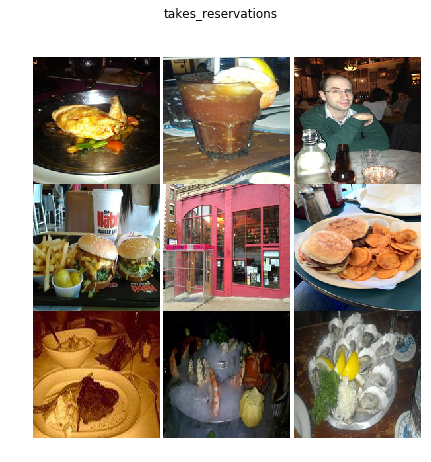

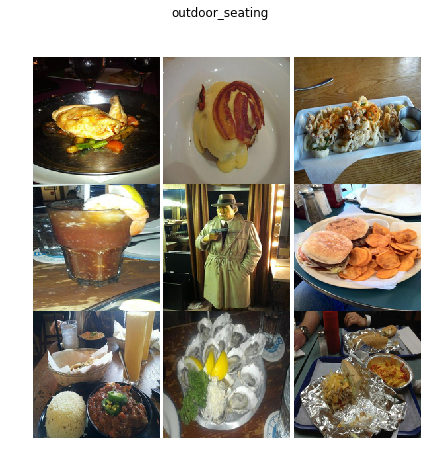

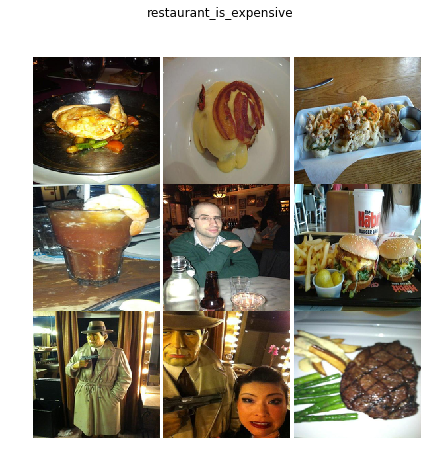

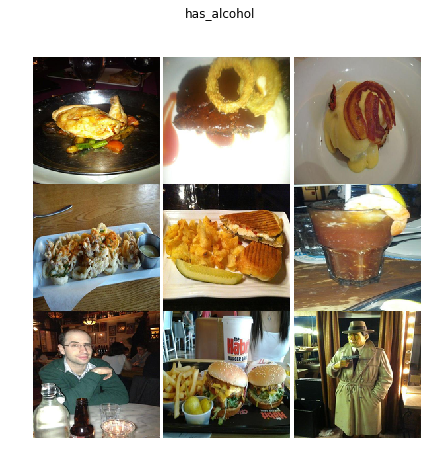

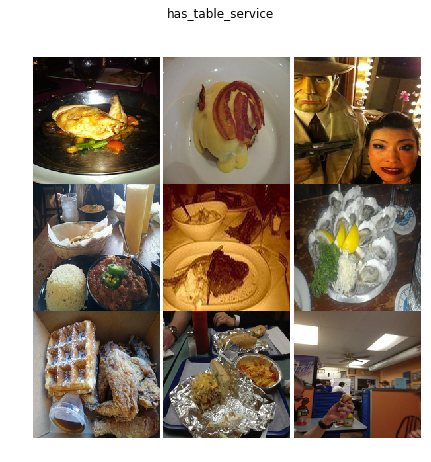

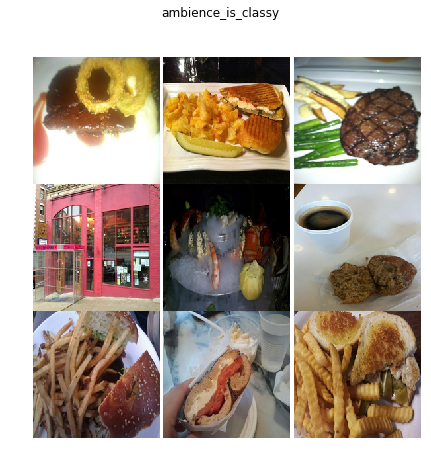

<Figure size 504x504 with 0 Axes>

In [5]:
# Show 9 images belonged to each label
for l in label_notation:
    ids = train_attr[train_attr['labels'].str.contains(str(l))==True].business_id.tolist()[:9]
    plt.rcParams['figure.figsize'] = (7.0, 7.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for x in range(9):
        plt.subplot(3, 3, x+1)
        im = Image.open(train_path + str(train_photos.photo_id[ids[x]]) + '.jpg')
        im = im.resize((192, 192), Image.ANTIALIAS)
        plt.imshow(im)
        plt.axis('off')
    fig = plt.figure()
    fig.suptitle(label_notation[l])

In [6]:
from tqdm import tqdm # Enable progress bar
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions # Load pre-trained model
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Flatten, Input

Using TensorFlow backend.


In [ ]:
# Use ResNet50 model to extract bottleneck features
ResNet_model = ResNet50(weights='imagenet', include_top = False)

# Construct a feature extractor based on pre-trained model
input = Input(shape=(224, 224, 3), name='image_input')
feature_extractor = ResNet_model(input)
flattener = Flatten()(feature_extractor)
bottleneck_feature_extractor = Model(inputs=input, outputs=flattener)

# Empty arrays for storing extracted features
X_train = []; X_test = []

# Extract bottleneck features of photos for traninig
for i in tqdm(range(len(train_photos))):
    img_path = train_path + str(train_photos.photo_id[i]) + '.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    bottleneck_features_train_raw = bottleneck_feature_extractor.predict(x)
    bottleneck_features_train_reduced =  bottleneck_features_train_raw.squeeze()
    X_train.append(bottleneck_features_train_reduced)

# Extract bottleneck features of photos for testing    
for i in tqdm(range(len(test_photos))):
    img_path = test_path + str(test_photos.photo_id[i]) + '.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    bottleneck_features_test_raw = bottleneck_feature_extractor.predict(x)
    bottleneck_features_test_reduced =  bottleneck_features_test_raw.squeeze()
    X_test.append(bottleneck_features_test_reduced)

94658560/94653016 [==============================] - 6s 0us/step


 75%|███████▍  | 888365/1190225 [8:33:03<2:54:20, 28.86it/s]

In [ ]:
# With extracted features, make a new train set by concatenating with photo_id in an original train set 
bottleneck_features_train = pd.DataFrame({'features' : X_train})
train_merge = pd.concat([bottleneck_features_train, train_photos], axis=1)
train_merge.to_pickle('train_merge.csv') # Save in pickle for preserving array format and considering its size

# With extracted features, make a new test set by concatenating with photo_id in an original test set 
bottleneck_features_test = pd.DataFrame({'features' : X_test})
test_merge = pd.concat([bottleneck_features_test, test_photos], axis=1)
test_merge.to_pickle('test_merge.csv') # Save in pickle for preserving array format and considering its size

In [ ]:
# Test loading data
train_merge = pd.read_pickle('train_merge.csv')
test_merge = pd.read_pickle('test_merge.csv')

# Check if the data frame is loaded normally
test_merge.head()

In [ ]:
"""
    Step 2. Business feature manipulation
"""
# Take average of all features of photos in a train set that are assigned to the same business id
train_bid_features = pd.DataFrame(train_merge.groupby('business_id')['features'].apply(np.mean))
train_bid_features.reset_index(level=0, inplace=True)

# Take average of all features of photos in a test set that are assigned to the same business id
test_bid_features = pd.DataFrame(test_merge.groupby('business_id')['features'].apply(np.mean))
test_bid_features.reset_index(level=0, inplace=True)

# Check if the data frame is well constructed
test_bid_features.head()

In [ ]:
# Sort labels by business_id in an ascending order, and then merge the label with mean feature of each business id
train_label = train_label.sort_values('business_id')
train_label = train_label.reset_index(drop=True)
train_bid_features['labels'] = train_label['labels']

# Find NaN label values and remove the row
nan_label_indices = pd.isnull(train_bid_features).any(1).nonzero()[0]
train_bid_features = train_bid_features.drop(train_bid_features.index[list(nan_label_indices)])

# Check if the data frame is well constructed
train_bid_features.head()

In [38]:
# Save the manipulated train & test data sets in pickle for preserving array format and considering its size
train_bid_features.to_pickle('train_set.csv')
test_bid_features.to_pickle('test_set.csv')